In [57]:
import pandas as pd
import numpy as np
from scipy.signal import find_peaks
import matplotlib.pyplot as plt

The Beauro of transportation Statistics claims that once freight index reaches a peak and decreases Real GDP follows that tread

In [58]:
tsi = pd.read_excel('/Users/sean/Downloads/CapstoneProject/TServiceIndexSeasonally-AdjustedTransportationData.xlsx')
tsi.rename(columns={'OBS_DATE': 'Date'}, inplace = True)
tsi.columns
col = ['Date','TSI_Freight']
freight_index = tsi[col]
real_gdp = pd.read_excel('/Users/sean/Downloads/CapstoneProject/RealGDP.xls')

In [59]:
freight_index

,Date,TSI_Freight
0,01/01/2000,105.1
1,02/01/2000,103.0
2,03/01/2000,99.8
3,04/01/2000,97.9
4,05/01/2000,98.8
...,...,...
285,10/01/2023,138.5
286,11/01/2023,137.6
287,12/01/2023,138.2
288,01/01/2024,134.0


In [60]:
real_gdp

,Date,RealGDP
0,2002-01-01,71.407
1,2002-04-01,73.597
2,2002-07-01,74.449
3,2002-10-01,75.726
4,2003-01-01,73.073
...,...,...
84,2023-01-01,110.451
85,2023-04-01,113.592
86,2023-07-01,115.086
87,2023-10-01,117.510


/var/folders/nc/t0bfgq115g94dvnn3jc3fsq00000gn/T/ipykernel_43484/3110652062.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  freight_index['Date'] = pd.to_datetime(freight_index['Date'], format='%m/%d/%Y')
/var/folders/nc/t0bfgq115g94dvnn3jc3fsq00000gn/T/ipykernel_43484/3110652062.py:28: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  peak_gdp['RealGDP'].fillna(method='ffill', inplace=True)
/var/folders/nc/t0bfgq115g94dvnn3jc3fsq00000gn/T/ipykernel_43484/3110652062.py:29: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  decline_gdp['RealGDP'].fillna(method='ffill', inplace=

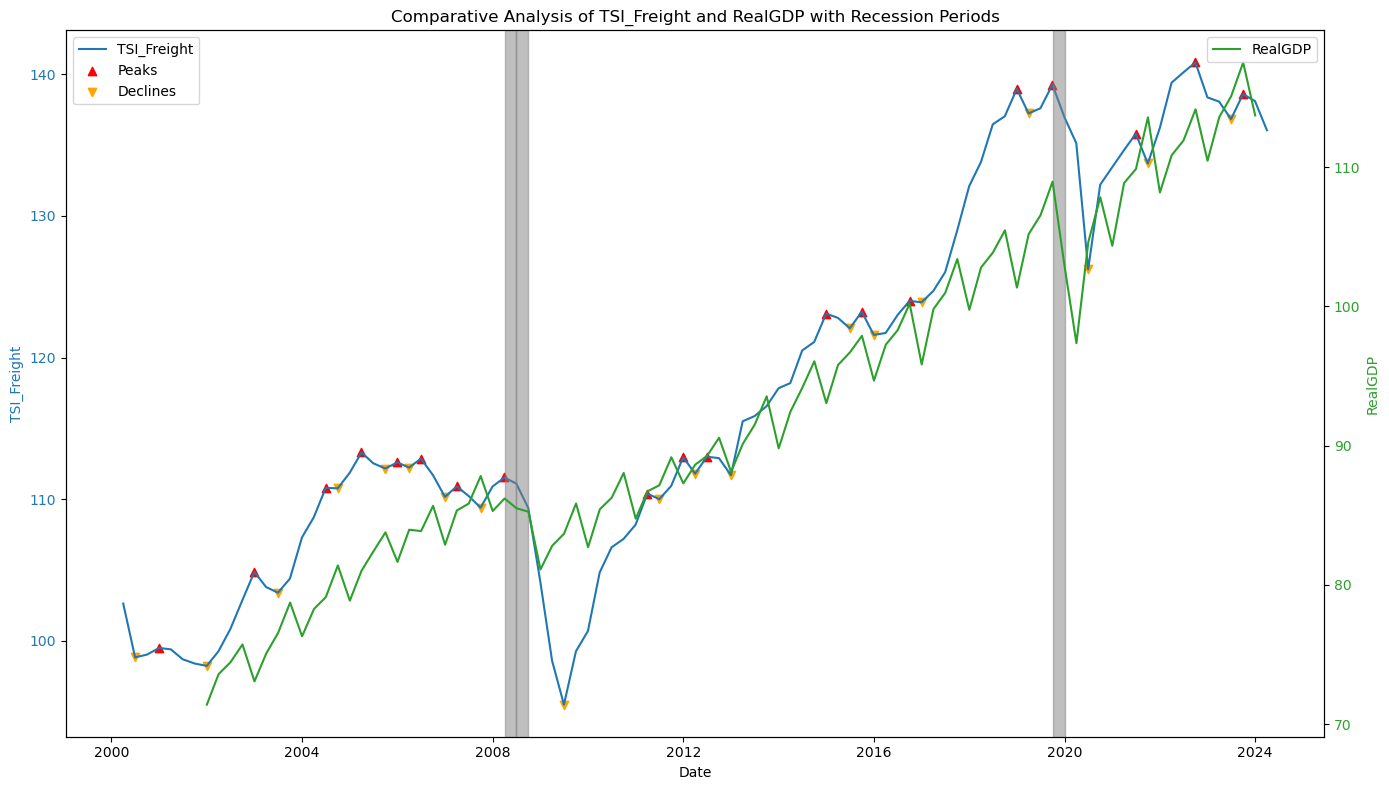

TSI_Freight peaks and subsequent declines:
         Date  TSI_Freight
3  2000-12-31    99.500000
11 2002-12-31   104.866667
17 2004-06-30   110.800000
20 2005-03-31   113.300000
23 2005-12-31   112.600000
25 2006-06-30   112.866667
28 2007-03-31   110.900000
32 2008-03-31   111.533333
44 2011-03-31   110.400000
47 2011-12-31   112.966667
49 2012-06-30   113.000000
59 2014-12-31   123.100000
62 2015-09-30   123.233333
66 2016-09-30   124.000000
75 2018-12-31   138.966667
78 2019-09-30   139.266667
85 2021-06-30   135.800000
90 2022-09-30   140.833333
94 2023-09-30   138.600000
         Date  TSI_Freight
1  2000-06-30    98.833333
7  2001-12-31    98.233333
13 2003-06-30   103.400000
18 2004-09-30   110.766667
22 2005-09-30   112.166667
24 2006-03-31   112.233333
27 2006-12-31   110.166667
30 2007-09-30   109.400000
37 2009-06-30    95.500000
45 2011-06-30   110.000000
48 2012-03-31   111.800000
51 2012-12-31   111.700000
61 2015-06-30   122.066667
63 2015-12-31   121.600000
67 2016-12-3

In [61]:

# Clean up column names by stripping any leading/trailing spaces
real_gdp.columns = real_gdp.columns.str.strip()

# Convert Date columns to datetime
freight_index['Date'] = pd.to_datetime(freight_index['Date'], format='%m/%d/%Y')
real_gdp['Date'] = pd.to_datetime(real_gdp['Date'])

# Resample freight index data to quarterly frequency
freight_index.set_index('Date', inplace=True)
freight_df = freight_index.resample('Q').mean()

# Reset index to get Date back as a column
freight_df.reset_index(inplace=True)

# Find peaks and declines in the TSI_Freight data
peaks, _ = find_peaks(freight_df['TSI_Freight'])
declines, _ = find_peaks(-freight_df['TSI_Freight'])

# Extract dates of peaks and declines
peak_dates = freight_df.loc[peaks, 'Date']
decline_dates = freight_df.loc[declines, 'Date']

# Merge RealGDP data with peak and decline dates using merge_asof
peak_gdp = pd.merge_asof(peak_dates.to_frame(), real_gdp, on='Date', direction='backward')
decline_gdp = pd.merge_asof(decline_dates.to_frame(), real_gdp, on='Date', direction='backward')

# Handling NaN values by forward filling the RealGDP values
peak_gdp['RealGDP'].fillna(method='ffill', inplace=True)
decline_gdp['RealGDP'].fillna(method='ffill', inplace=True)

# Function to check for two consecutive quarters of GDP decline
def check_recession(gdp_series):
    return (gdp_series.diff().lt(0) & gdp_series.diff().shift(-1).lt(0)).any()

# Check for recession in the entire GDP data
real_gdp['Recession'] = (real_gdp['RealGDP'].diff().lt(0) & real_gdp['RealGDP'].diff().shift(-1).lt(0)).astype(int)

# Merge recession data back to peaks and declines for context
peak_gdp = pd.merge_asof(peak_gdp, real_gdp[['Date', 'Recession']], on='Date', direction='backward')
decline_gdp = pd.merge_asof(decline_gdp, real_gdp[['Date', 'Recession']], on='Date', direction='backward')

# Plot the data
fig, ax1 = plt.subplots(figsize=(14, 8))

# Plot TSI_Freight
ax1.plot(freight_df['Date'], freight_df['TSI_Freight'], color='tab:blue', label='TSI_Freight')
ax1.set_xlabel('Date')
ax1.set_ylabel('TSI_Freight', color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

# Highlight peaks and declines
ax1.scatter(peak_dates, freight_df.loc[peaks, 'TSI_Freight'], color='red', label='Peaks', marker='^')
ax1.scatter(decline_dates, freight_df.loc[declines, 'TSI_Freight'], color='orange', label='Declines', marker='v')

# Create a second y-axis to plot RealGDP
ax2 = ax1.twinx()
ax2.plot(real_gdp['Date'], real_gdp['RealGDP'], color='tab:green', label='RealGDP')
ax2.set_ylabel('RealGDP', color='tab:green')
ax2.tick_params(axis='y', labelcolor='tab:green')

# Highlight recession periods
for i, row in real_gdp.iterrows():
    if row['Recession']:
        ax2.axvspan(row['Date'] - pd.DateOffset(months=3), row['Date'], color='gray', alpha=0.5)

# Add title and legends
plt.title('Comparative Analysis of TSI_Freight and RealGDP with Recession Periods')
fig.tight_layout()
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# Show the plot
plt.show()

# Print results
print("TSI_Freight peaks and subsequent declines:")
print(freight_df.loc[peaks])
print(freight_df.loc[declines])

print("\nRealGDP at corresponding dates:")
print(peak_gdp)
print(decline_gdp)


The purpose of this analysis was to test the effectiveness of the Transportation Freight Index as an economic condition predictor. This graph shows that as the Freight Index peaks and then declines, U.S. Real GDP follows in the subsequent quarters. Although the two major recessions over the last twenty years were preceded by peaks in the Freight Index, this analysis alone does not provide sufficient evidence to classify it as a definitive recession predictor.